In [ ]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import seaborn as sns
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio.transform import Affine

import matplotlib.pyplot as plt

# Set the working directory
wd = r"G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UC_run\intermediate"
wd_shp = r"G:\Shared drives\Wellcome Trust Project Data\1_preprocess\UrbanCoolingModel"
figures_dir = r"G:\Shared drives\Wellcome Trust Project Data\3_final"
os.chdir(wd)

# Using os.getcwd()
current_directory_os = os.getcwd()
print(f"Current directory: {current_directory_os}")

admin_shapefile = os.path.join(wd_shp, "London_Borough_aoi.shp")  # Administrative boundary (e.g., census tracts)
# Load administrative boundaries
gdf = gpd.read_file(admin_shapefile)

C:\Users\pc\AppData\Local\Temp\ipykernel_24300\1786103854.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")  # Optional clean background


Current directory: G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UC_run\intermediate


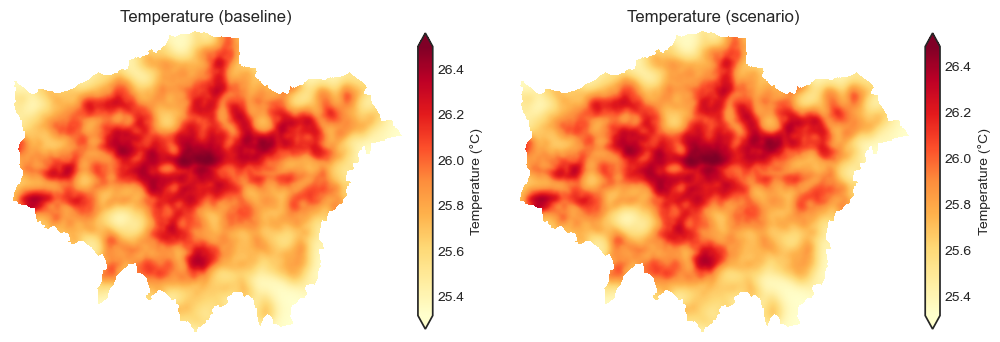

In [51]:
# data version 
v = 'v5'


import seaborn as sns
sns.set_style("white")  # 'whitegrid', 'darkgrid', etc. also available


# --- Step 1: Define File Paths ---
temp1_path = "T_air_v5_baseline_july_work.tif"  # First temperature raster (older year)
temp2_path = "T_air_v5_scenario_july_work.tif"  # Second temperature raster (newer year)
# Define output file path
temp_change_output_path = "T_air_v5_change.tif"


# --- Step 2: Load and Visualize the Two Temperature Maps ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
with rasterio.open(temp1_path) as src1, rasterio.open(temp2_path) as src2:

    # The value -3.402823e+38 in a raster is a common placeholder for "no data" or missing values, 
    #  especially in float32 rasters (it's the minimum float32 value)
    nodata = src1.nodata  # should return -3.402823e+38
    temp1 = src1.read(1)  # Read first band
    temp2 = src2.read(1)

    temp1 = np.where(temp1 == nodata, np.nan, temp1)
    temp2 = np.where(temp2 == nodata, np.nan, temp2)

    extent = [src1.bounds.left, src1.bounds.right, src1.bounds.bottom, src1.bounds.top]
    transform = src1.transform  # Get affine transformation
    temp_meta = src1.meta.copy()  # Copy metadata

    # Plot the first temperature map
    im1 = axes[0].imshow(temp1, cmap="YlOrRd", extent=extent, origin="upper")
    axes[0].set_title("Temperature (baseline)")
    axes[0].set_axis_off()  # Removes ticks, labels, and frame
    plt.colorbar(im1, ax=axes[0], label="Temperature (°C)", extend = 'both', fraction=0.035, pad=0.04)

    # Plot the second temperature map
    im2 = axes[1].imshow(temp2, cmap="YlOrRd", extent=extent, origin="upper")
    axes[1].set_title("Temperature (scenario)")
    axes[1].set_axis_off()
    plt.colorbar(im2, ax=axes[1], label="Temperature (°C)", extend = 'both', fraction=0.035, pad=0.04)

# Save the figure
f = "temperature_2_scenarios_" + v + ".png"
output_plot_path = os.path.join(figures_dir, f)
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()


In [27]:
# Flatten the array and remove NaN values
temp_flat = temp1.ravel()
temp_flat = temp_flat[np.isfinite(temp_flat)]  # Remove NaNs

# Summary Statistics
summary_stats = pd.Series(temp_flat).describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
 count    3.661025e+07
mean     2.588334e+01
std      2.505083e-01
min      2.531572e+01
1%       2.535786e+01
10%      2.554827e+01
25%      2.571045e+01
50%      2.587111e+01
75%      2.606436e+01
90%      2.623312e+01
99%      2.640208e+01
99.9%    2.648060e+01
max      2.649916e+01
dtype: float64


## Change in T_air map

In [17]:


# --- Step 3: Calculate Temperature Change ---
temp_change = temp2 - temp1  # Compute difference (Temp2 - Temp1)

# Set values > 5 to NaN
temp_change[temp_change > 5] = np.nan


# Update metadata to handle float32 values
temp_meta.update(dtype="float32", nodata=np.nan)  # Ensure nodata is set

# Save the temperature change raster
with rasterio.open(temp_change_output_path, "w", **temp_meta) as dst:
    dst.write(temp_change.astype("float32"), 1)

print(f"Temperature change raster saved: {temp_change_output_path}")

Temperature change raster saved: T_air_v5_change.tif


Summary Statistics:
 count    3.661025e+07
mean    -6.008335e-03
std      1.004882e-02
min     -1.835060e-01
1%      -4.789924e-02
10%     -1.386833e-02
25%     -6.759643e-03
50%     -2.952560e-03
75%     -1.134872e-03
90%     -3.662109e-04
99%     -2.479560e-05
99.9%    1.528561e-05
max      1.024808e-04
dtype: float64
Pixels with value > 0: 70960


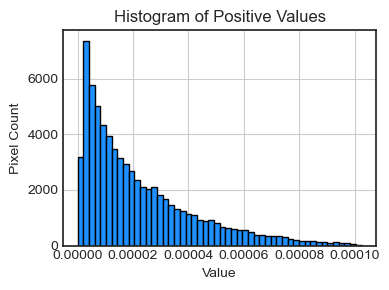

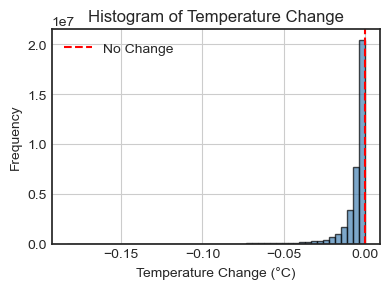

In [45]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Flatten the array and remove NaN values
temp_change_flat = temp_change.ravel()
temp_change_flat = temp_change_flat[np.isfinite(temp_change_flat)]  # Remove NaNs

# Summary Statistics
summary_stats = pd.Series(temp_change_flat).describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
print("Summary Statistics:\n", summary_stats)



# Count pixels > 0
count = np.sum((temp_change > 0) & (~np.isnan(temp_change)))
print(f"Pixels with value > 0: {count}")


# --- Filter positive values only ---
positive_values = temp_change[temp_change > 0]

# --- Plot histogram if any positive values exist ---
if positive_values.size > 0:
    plt.figure(figsize=(4, 3))
    plt.hist(positive_values, bins=50, color="dodgerblue", edgecolor="black")
    plt.title("Histogram of Positive Values")
    plt.xlabel("Value")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No positive values in raster.")





# --- Step 1: Histogram of Temperature Change ---
plt.figure(figsize=(4, 3))
plt.hist(temp_change_flat, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
plt.axvline(x=0, color="red", linestyle="--", label="No Change")  # Add a vertical line at 0
plt.xlabel("Temperature Change (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Temperature Change")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
f = "temperature_change_Histogram_" + v + ".png"
output_plot_path = os.path.join(figures_dir, f)
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()



# # Plot temperature change map
# fig, ax = plt.subplots(figsize=(8, 6))
# im = ax.imshow(temp_change, cmap="bwr", extent=extent, origin="upper")  # Blue-Red for changes
# plt.colorbar(im, label="Temperature Change (°C)")
# plt.title("Temperature Change (2000-2020)")
# plt.show()




## Map

### change map 1

max_val: 0.0001024808


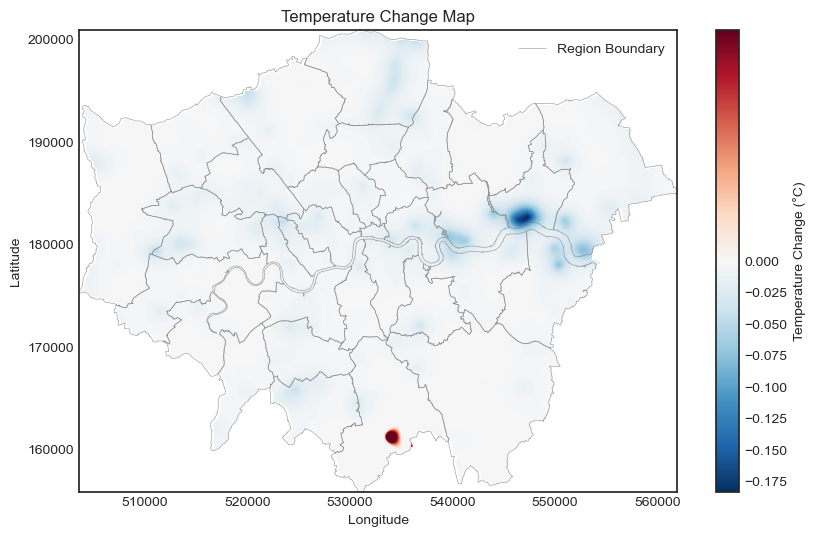

In [19]:
import matplotlib.colors as mcolors


# Open the temperature change raster
with rasterio.open(temp_change_output_path) as src:
    temp_change = src.read(1)  # Read first band
    transform = src.transform  # Get transform info
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]



## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Check if all values are negative
# if np.nanmax(temp_change) <= 0:
#     cmap = "Blues"  # Use a single-hue blue color scale
# else:
#     cmap = "RdBu_r"  # Use diverging red-blue if both positive & negative exist

# # Define a custom normalization: zero values in white
# norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(temp_change), vcenter=0, vmax=np.nanmax(temp_change))
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## ----------------------------------------------------------
# Compute value distribution
min_val = np.nanmin(temp_change)
max_val = np.nanmax(temp_change)
print('max_val:', max_val)

# If all values are negative, use a single-hue colormap
if max_val <= 0:
    cmap = "Blues"
else:
    cmap = "RdBu_r"  # Diverging colormap

# Custom normalization: Zero in white, shorten positive range
if min_val < 0 < max_val:
    pos_percentile = np.percentile(temp_change[temp_change > 0], 70)  # Focus on 85% quantile for positive values
    norm = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=pos_percentile)
else:
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
## ----------------------------------------------------------


# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the temperature change raster
im = ax.imshow(temp_change, cmap=cmap, norm=norm, extent=extent, origin="upper")

# Overlay the shapefile boundary
gdf.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, alpha=0.7, label="Region Boundary")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Temperature Change (°C)")

# Formatting
plt.title("Temperature Change Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.legend()

# # Save the figure
# f = "temperature_change_map_" + v + ".png"
# output_plot_path = os.path.join(figures_dir, f)
# plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

# Show the plot
plt.show()



### change map 2 - better

[-0.18350601196289062, -0.1529216766357422, -0.12233734130859375, -0.09175300598144531, -0.061168670654296875, -0.030584335327148438, 0.0, 3.416026690198729e-05, 6.832053380397458e-05, 0.00010248080070596188]


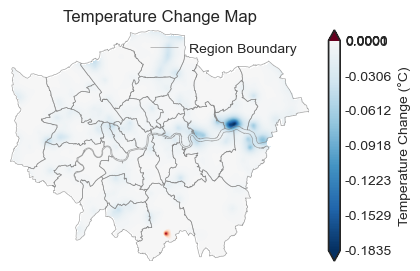

In [ ]:

min_val = np.nanmin(temp_change)
max_val = np.nanmax(temp_change)

# Anchor at zero if there's negative and positive data
if min_val < 0 and max_val > 0:
    vcenter = 0
else:
    vcenter = (min_val + max_val) / 2

# Avoid degenerate color range
if min_val >= max_val:
    max_val = min_val + 1e-6

# Build color norm: negative=red, positive=blue
norm = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=vcenter, vmax=max_val)
color_map = plt.cm.RdBu


# -------------------------------
# Enhanced Colorbar Definition
# -------------------------------
# We'll create a set of ticks that includes min_val, 0 (if in range), and max_val,
# plus extra ticks for intermediate values.

ticks = [min_val]
# If zero is in range, add it
if min_val < 0 < max_val:
    ticks.append(0)
# Then add the max_val
ticks.append(max_val)

# Optionally, add intermediate steps. For example, 3 extra steps between min->0 and 3 extra steps between 0->max.
# You can fine-tune how many intermediate ticks you want.
num_intermediates = 3
if min_val < 0 < max_val:
    neg_ticks = np.linspace(min_val, 0, num_intermediates + 4)  # exclude endpoints
    pos_ticks = np.linspace(0, max_val, num_intermediates + 1)
    ticks = np.concatenate([neg_ticks, [0], pos_ticks])
else:
    # If purely negative or purely positive, just do a simple linear space
    ticks = np.linspace(min_val, max_val, num_intermediates + 4)

ticks = sorted(list(set(ticks)))  # Ensure sorted and unique

print(ticks)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the temperature change raster
im = ax.imshow(temp_change, cmap=cmap, norm=norm, extent=extent, origin="upper")

# Overlay the shapefile boundary
gdf.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, alpha=0.7, label="Region Boundary")

# Add colorbar with adjusted scale
cbar = plt.colorbar(im, ax=ax, extend = 'both')
cbar.ax.set_yscale('linear')
cbar.set_label("Temperature Change (°C)")
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels([f"{t:.4f}" for t in ticks])

# Formatting
plt.title("Temperature Change Map")
ax.set_axis_off()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.legend()

# Save the figure
f = "temperature_change_map_" + v + ".png"
output_plot_path = os.path.join(figures_dir, f)
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

# Show the plot
plt.show()

## Temperature Change by Borough 

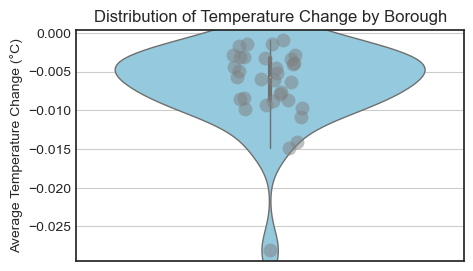

In [49]:


# --- Step 5: Violin Plot by Administrative Region ---
# Compute zonal statistics (mean temperature change per region)
zonal_stats_result = zonal_stats(admin_shapefile, temp_change, stats=["mean"], affine=transform)
gdf["temp_change_mean"] = [z["mean"] for z in zonal_stats_result]  # Add results to GeoDataFrame


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert zonal stats to DataFrame
df_zonal = pd.DataFrame(zonal_stats_result)
df_zonal["GSS_CODE"] = gpd.read_file(admin_shapefile)["GSS_CODE"]  # Assuming GSS_CODE exists
df_zonal["temp_change_mean"] = [z["mean"] for z in zonal_stats_result]

# Plot Violin Plot with Jittered Points
plt.figure(figsize=(5, 3))

# Violin Plot (Temperature Change Distribution by Region)
sns.violinplot(y=df_zonal["temp_change_mean"], 
            
               color="skyblue",
               linewidth=1,  # Border thickness
               # inner="quartile", 
               # inner_kws=dict(box_width=25, whis_width=4, color="silver")
               # line_kws={"color": "red", "linewidth": 5}  # Custom quartile line color
               )

# Jittered Points (to show actual data points)
sns.stripplot(y=df_zonal["temp_change_mean"], color="gray", size=10, jitter=True, alpha=0.5)

# Labels & Formatting
plt.ylabel("Average Temperature Change (°C)")
plt.title("Distribution of Temperature Change by Borough")
plt.grid(True)

# Save plot
f = "temperature_change_violin_plot_Borough_" + v + ".png"
output_plot_path = os.path.join(figures_dir, f)
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

# Show Plot
plt.show()

